### Example of a flux driven flow

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy as np

Setup parameters
-----

In [2]:
# Set domain dimension & size
dim = 2
boxHeight = 1.0
boxLength = 1.0
# Set grid resolution.
res = 20

# Set a constant viscosity.
viscosity = 5.


In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (-1., 0.), 
                                 maxCoord    = (boxLength, boxHeight),
                                 periodic = (False,False))

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
dphi_dx         = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

# initialise velocity, pressure and temperatureDot field
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
dphi_dx.data[:]         = [0.0,0.0,0.0]

Create boundary conditions
----------

Set temperature boundary conditions on the bottom ( ``MinJ`` ) and top ( ``MaxJ`` ).

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the ``I`` (left and right side walls) and ``J`` (top and bottom walls) sets. Note that both sets contain the corners of the box.


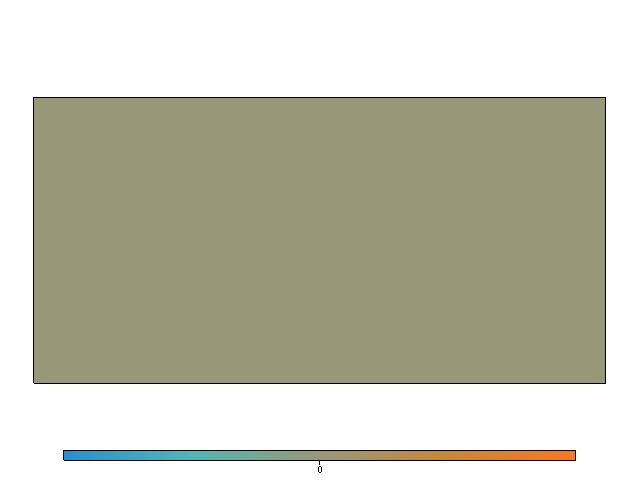

In [4]:
fig = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig.append( glucifer.objects.Surface( mesh, velmagfield ) )
fig.show()

In [5]:
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
allWalls = iWalls + jWalls

In [6]:
vBC = uw.conditions.DirichletCondition( variable = velocityField, 
                                        indexSetsPerDof = (jWalls, allWalls) )

# constant stress definition
xcoord = fn.coord()[0]
stress = viscosity*xcoord*(1.,0.,0.0) 

# This stress is multiplied by the wall normal to produce a surface force, via divergence-theorem
# The left wall normal unit vector is (-1,0)
# The right wall normal unit vector is (1,0)
# stress_i_j * normal_j = surface_force

nbc = uw.conditions.NeumannCondition( stress, 
                                      variable=velocityField,
                                      indexSetsPerDof=(iWalls,None) )

In [7]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [vBC, nbc],
                               fn_viscosity   = viscosity, 
                               fn_bodyforce   = 0.0 )

solver = uw.systems.Solver( stokesPIC )
solver.solve()


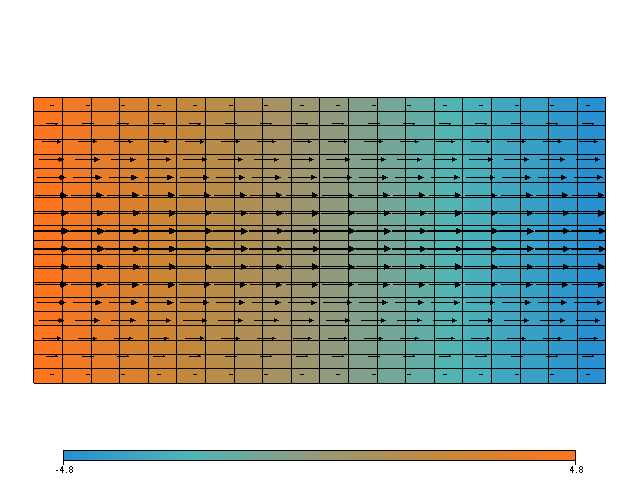

In [8]:
fig = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=1) )
fig.append( glucifer.objects.Mesh(mesh) )
fig.append( glucifer.objects.Surface( mesh, pressureField ) )
fig.show()

In [9]:
# coords = np.zeros(shape=(resx, 2))
# coords[:,1] = (boxHeight/resy)
# offset = 0.5*(rWallx-lWallx)/resx
# for i in xrange(resx):
#     coords[i,0] = offset+i*(rWallx-lWallx)/resx
# print coords

ids = mesh.specialSets["MaxI_VertexSet"]
coords = mesh.data[ids.data] # xcoords

dv_dy = velocityField.fn_gradient.evaluate(ids)[:,3]
du_dx = velocityField.fn_gradient.evaluate(ids)[:,0]
shear = velocityField.fn_gradient.evaluate(ids)[:,1]
v = velocityField.evaluate(ids)[:,1]
u = velocityField.evaluate(ids)[:,0]
gradV = velocityField.fn_gradient.evaluate(ids)
dev_xx = viscosity*2*gradV[:,0]
dev_yy = viscosity*2*gradV[:,3]
dev_xy = viscosity*(gradV[:,1]+gradV[:,2])

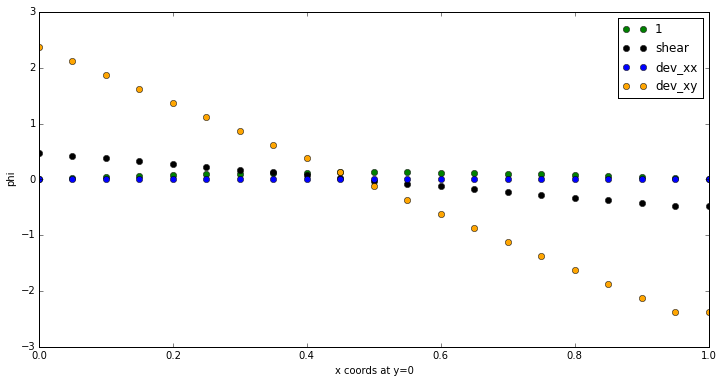

In [10]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
pylab.rcParams[ 'figure.figsize'] = 12, 6
pyplot.plot(coords[:,1], u, 'o', color = 'green', label='1')
# pyplot.plot(coords[:,1], v, 'o', color = 'red', label='2')
pyplot.plot(coords[:,1], shear, 'o', color = 'black', label='shear')
pyplot.plot(coords[:,1], dev_xx, 'o', color = 'blue', label='dev_xx')
pyplot.plot(coords[:,1], dev_xy, 'o', color = 'orange', label='dev_xy')
pyplot.legend()
pyplot.xlabel('x coords at y=0')
pyplot.ylabel('phi')
pyplot.show()